In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.utils import plot_model
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report, roc_curve
%load_ext tensorboard
import utils
import pickle

import random

In [2]:
#person = 'Davis'
person = 'JOURNEY HOUSE TRAVEL INC'
cat_vars = ['Merchant Category Code (MCC)']
numeric_vars = ['Amount']
categories = ['Cardholder Last Name', 'Cardholder First Initial'] + numeric_vars + cat_vars

In [3]:
df = utils.get_df()

In [4]:
transations = utils.get_person_true_transations_df(df, person, categories, cat_vars, numeric_vars)
df_transations = transations[0][0]
labels = transations[1][0]

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.2, random_state=42)

# Normalize the testing and training data using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
x_train = scaler.fit_transform(df_transations)
x_test = scaler.transform(x_test)
# convert the data to FP32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

input_dim = x_train.shape[1]

In [6]:
# model hyperparameters
latent_dim = 10
max_epochs = 15
learning_rate = 0.001


opt = optimizers.Adam(learning_rate=learning_rate)
activator = tf.keras.layers.LeakyReLU(alpha=0.01)

In [7]:
def create_model():
    input_data = Input(shape=(input_dim,), name='encoder_input')
    
    dimensions = [200, 100, 50]
    dim = input_dim//2
    #while dim > 2*latent_dim:
    #    dimensions.append(dim)
    #    dim = dim//3

    encoder = Dense(dimensions[0],activation=activator, name='encoder_1')(input_data)
    encoder = Dropout(.1)(encoder)

    lay = 1
    for num in dimensions[1:]:
        lay += 1
        encoder = Dense(num,activation=tf.keras.layers.LeakyReLU(alpha=0.01), name='encoder_'+str(lay))(encoder)
        encoder = Dropout(.1)(encoder)
        
    latent_encoding = Dense(latent_dim, activation='linear', name='latent_encoding')(encoder)

    decoder = Dense(dimensions[-1] , activation=tf.keras.layers.LeakyReLU(alpha=0.01), name='decoder_1')(latent_encoding)
    decoder = Dropout(.1)(decoder)
    dimensions.pop()

    lay = 1
    for num in dimensions[::-1]:
        lay += 1
        decoder = Dense(num, activation=tf.keras.layers.LeakyReLU(alpha=0.01), name='decoder_'+ str(lay))(decoder)
        decoder = Dropout(.1)(decoder)
    
    reconstructed_data = Dense(input_dim, activation='linear', name='reconstructed_data')(decoder)
    
    autoencoder_model = Model(input_data, reconstructed_data)
    encoder_model = Model(input_data, latent_encoding)
    autoencoder_model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
    encoder_model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
    return autoencoder_model, encoder_model

In [16]:
autoencoder_model, encoder_model = create_model()

In [17]:
autoencoder_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 435)]             0         
                                                                 
 encoder_1 (Dense)           (None, 200)               87200     
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 encoder_2 (Dense)           (None, 100)               20100     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 encoder_3 (Dense)           (None, 50)                5050      
                                                                 
 dropout_8 (Dropout)         (None, 50)                0   

In [18]:
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,profile_batch=0,update_freq='epoch',histogram_freq=1)
batch_size = len(x_train)//10
train_history = autoencoder_model.fit(x_train, x_train,
        shuffle=True,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test)
        #callbacks=[tensorboard_callback]
        )

Epoch 1/15
10/10 [==============================] - 1s 125ms/step - loss: 0.0021 - accuracy: 0.4106 - val_loss: 0.0016 - val_accuracy: 0.4534
Epoch 2/15
10/10 [==============================] - 1s 104ms/step - loss: 0.0015 - accuracy: 0.5668 - val_loss: 0.0011 - val_accuracy: 0.7010
Epoch 3/15
10/10 [==============================] - 1s 101ms/step - loss: 0.0011 - accuracy: 0.7104 - val_loss: 7.0125e-04 - val_accuracy: 0.7010
Epoch 4/15
10/10 [==============================] - 1s 117ms/step - loss: 7.8549e-04 - accuracy: 0.8340 - val_loss: 5.2809e-04 - val_accuracy: 0.8798
Epoch 5/15
10/10 [==============================] - 1s 111ms/step - loss: 6.0866e-04 - accuracy: 0.8960 - val_loss: 3.6701e-04 - val_accuracy: 0.8798
Epoch 6/15
10/10 [==============================] - 1s 122ms/step - loss: 4.6662e-04 - accuracy: 0.9040 - val_loss: 2.7746e-04 - val_accuracy: 0.8798
Epoch 7/15
10/10 [==============================] - 1s 122ms/step - loss: 3.8309e-04 - accuracy: 0.9512 - val_loss: 2.26

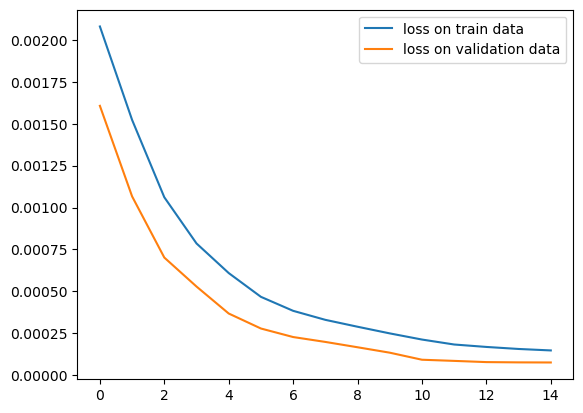

In [20]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss on train data', 'loss on validation data'])

Autoencoder capability

<AxesSubplot:xlabel='Reconstruction Score', ylabel='Frequency'>

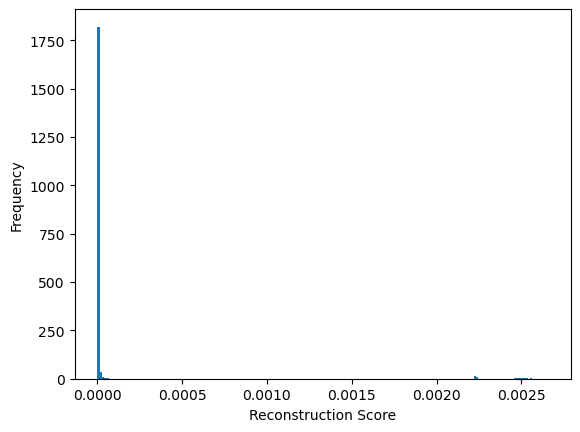

In [21]:
x_test_recon = autoencoder_model.predict(x_test)
reconstruction_scores = np.mean((x_test - x_test_recon)**2, axis=1)
plt.xlabel('Reconstruction Score')
df_a = pd.DataFrame()
df_a['recon_score'] = reconstruction_scores
minim, maxim = df_a['recon_score'].min(), df_a['recon_score'].max()
df_a['recon_score'].plot.hist(bins=200, range=[minim, maxim])

In [23]:
transations_val = utils.get_person_balanced_df(df, person, categories, cat_vars, numeric_vars)
df_transations_val = transations_val[0][0]
labels_val = transations_val[1][0]
scaler = MinMaxScaler()
x_test_val = scaler.fit_transform(df_transations_val)

x_test_recon_val = autoencoder_model.predict(x_test_val)
reconstruction_scores_val = np.mean((x_test_val - x_test_recon_val)**2, axis=1)
anomaly_data = pd.DataFrame({'recon_score':reconstruction_scores_val})
threshold = anomaly_data['recon_score'].median()
print("Threshold: ", threshold)

Threshold:  1.2728065078661983e-05


In [24]:
transations_val_2 = utils.get_person_total_df(df, person, categories, cat_vars, numeric_vars)
df_transations_val_2 = transations_val_2[0][0]
labels_val_2 = transations_val_2[1][0]
scaler = MinMaxScaler()
x_test_val_2 = scaler.fit_transform(df_transations_val_2)

x_test_recon = autoencoder_model.predict(x_test_val_2)
reconstruction_scores_2 = np.mean((x_test_val_2 - x_test_recon)**2, axis=1)
anomaly_data = pd.DataFrame({'recon_score':reconstruction_scores_2})
pred_labels_2 = (reconstruction_scores_2 < threshold).astype(int)

In [25]:
accuracy_score(pred_labels_2, labels_val_2)

0.9486802353315312

<AxesSubplot:xlabel='Reconstruction Score', ylabel='Frequency'>

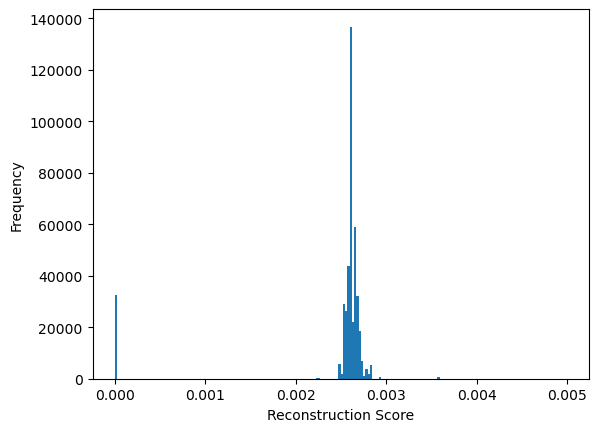

In [26]:
plt.xlabel('Reconstruction Score')
df_a = pd.DataFrame()
df_a['recon_score'] = reconstruction_scores_2
minim, maxim = df_a['recon_score'].min(), df_a['recon_score'].max()
df_a['recon_score'].plot.hist(bins=200, range=[minim, maxim])

Confusion Matrix: 


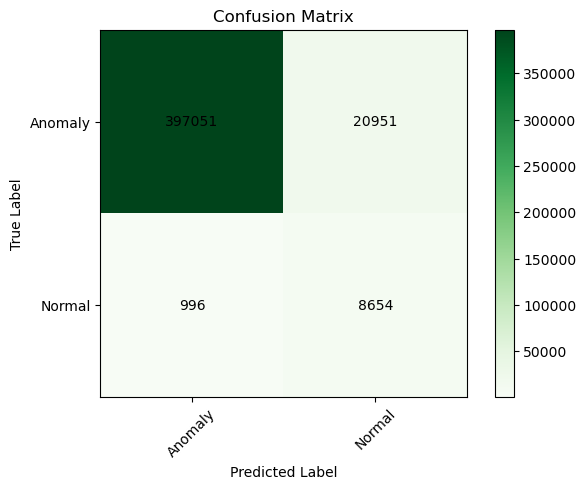

In [27]:
print ('Confusion Matrix: ')
results = confusion_matrix(labels_val_2, pred_labels_2) 
utils.plot_confusion_matrix(results, ['Anomaly','Normal'])

## For all persons

In [28]:
def calc_accuracy(name: str):
    #Train
    transations = utils.get_person_true_transations_df(df, person, categories, cat_vars, numeric_vars)
    df_transations = transations[0][0]
    labels = transations[1][0]
    x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.2, random_state=42)
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(df_transations)
    x_test = scaler.transform(x_test)
    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    autoencoder_model, encoder_model = create_model()
    batch_size = len(x_train)//10
    train_history = autoencoder_model.fit(x_train, x_train,
        shuffle=True,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test)
        #callbacks=[tensorboard_callback]
        )
    #Find Threshold
    transations_val = utils.get_person_balanced_df(df, person, categories, cat_vars, numeric_vars)
    df_transations_val = transations_val[0][0]
    labels_val = transations_val[1][0]
    scaler = MinMaxScaler()
    x_test_val = scaler.fit_transform(df_transations_val)
    x_test_recon_val = autoencoder_model.predict(x_test_val)
    reconstruction_scores_val = np.mean((x_test_val - x_test_recon_val)**2, axis=1)
    anomaly_data = pd.DataFrame({'recon_score':reconstruction_scores_val})
    threshold = anomaly_data['recon_score'].median()
    
    # Validate
    transations_val_2 = utils.get_person_total_df(df, person, categories, cat_vars, numeric_vars)
    df_transations_val_2 = transations_val_2[0][0]
    labels_val_2 = transations_val_2[1][0]
    scaler = MinMaxScaler()
    x_test_val_2 = scaler.fit_transform(df_transations_val_2)

    x_test_recon = autoencoder_model.predict(x_test_val_2)
    reconstruction_scores_2 = np.mean((x_test_val_2 - x_test_recon)**2, axis=1)
    anomaly_data = pd.DataFrame({'recon_score':reconstruction_scores_2})
    pred_labels_2 = (reconstruction_scores_2 < threshold).astype(int)

    return accuracy_score(labels_val_2, pred_labels_2)

In [29]:
persons = list(df['Cardholder Last Name'].unique())
quantities = df['Cardholder Last Name'].value_counts()
values = []
names = []

for person in persons:
    if quantities[person] > 1000:
        accuracy = calc_accuracy(person)
        values.append(accuracy) 
        names.append(quantities[person])

Epoch 1/15
11/11 [==============================] - 1s 67ms/step - loss: 0.0022 - accuracy: 0.2552 - val_loss: 0.0020 - val_accuracy: 0.3005
Epoch 2/15
11/11 [==============================] - 1s 57ms/step - loss: 0.0020 - accuracy: 0.3582 - val_loss: 0.0015 - val_accuracy: 0.4809
Epoch 3/15
11/11 [==============================] - 1s 59ms/step - loss: 0.0016 - accuracy: 0.4315 - val_loss: 0.0013 - val_accuracy: 0.4809
Epoch 4/15
11/11 [==============================] - 0s 36ms/step - loss: 0.0015 - accuracy: 0.4611 - val_loss: 0.0012 - val_accuracy: 0.5082
Epoch 5/15
11/11 [==============================] - 0s 42ms/step - loss: 0.0014 - accuracy: 0.4819 - val_loss: 0.0012 - val_accuracy: 0.5355
Epoch 6/15
11/11 [==============================] - 1s 49ms/step - loss: 0.0014 - accuracy: 0.5082 - val_loss: 0.0012 - val_accuracy: 0.5792
Epoch 7/15
11/11 [==============================] - 1s 56ms/step - loss: 0.0013 - accuracy: 0.5476 - val_loss: 0.0011 - val_accuracy: 0.5792
Epoch 8/15
11

: 

: 

In [ ]:
plt.figure()
plt.plot(names, values, ".")
plt.title("Accuracy vs Operations Quantities")
plt.xlabel("Operations Quantities")
plt.ylabel("Accuracy")

In [ ]:
values

In [ ]:
names